In [18]:
from utils import * 
from algorithms import *
from agents import *

In [19]:
numRounds, numPeriods, numSteps = 1, 10000, 10
numBuyers, numSellers, numTokens = 4, 4, 4
gameTypes, seed = '1111', 42
disclosure = ['bids', 'asks', 'currentBid', 'currentBidIdx','currentAsk', 'currentAskIdx', 'buy', 'sell', 'price', 'sale']
depth = 1
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
numStates = 18
numActions = 50
epsilon = 0.98
min_epsilon = 0.05
epsilon_decay = 0.9999
gamma = 0.98
lr = 0.0003
tau = 0.005
batch_size = 32
wait_period = 32
grad_steps = 1
reward_norm = False
eta = 0.5
buyers = [Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, numStates = 18,
                     algo='DQNPER',algoArgs = [numStates, numActions, epsilon, min_epsilon, 
                                            epsilon_decay, gamma, lr, tau, batch_size, wait_period, grad_steps, reward_norm, eta]),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0)]
sellers = [ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)]
log = Log(gameData, disclosure)
rnd = 0

In [20]:
print_interval = 1
for rnd in range(numRounds):
    startRounds(gameData, log, buyers, sellers, rnd)
    #print(log.roundData.buyerValues.item())
    score1, score2 = 0.0, 0.0
    ss1, ss2 = 0.0, 0.0
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        period_bids = []
        for step in range(numSteps):
            # start
            startSteps(buyers, sellers)

            # set state
            buyers[0].state = generateState(buyers[0], disclosure, depth)

            # trade
            bids, asks = collectOffers(buyers, sellers)
            period_bids.append(np.round(bids[0],1))
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits
            if currentBidIdx == 0:
                score1 += bprofit
                ss1 += bprofit
            elif currentBidIdx == 1:
                score2 += bprofit
                ss2 += bprofit
                
            log.addStep([rnd, period, step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
            observe(buyers, sellers, log.disclose())
            endSteps(buyers, sellers) # updates period counters

            buyers[0].newState  = generateState(buyers[0], disclosure, depth)

            if step == numSteps - 1:
                buyers[0].done = True
            else:
                buyers[0].done = False

            agentsObserve(buyers, sellers)
            agentsTrain(buyers, sellers)

        endPeriods(buyers, sellers)

        if period%100==0:
            print('\t',ss1/100, ss2/100,  period_bids)
            ss1 = 0
            ss2 = 0
        if period%print_interval==0 and period > 2:
            print(step, round(score1 / print_interval, 2), round(score2 / 100, 2), 
                  np.round(buyers[0].algo.epsilon,2), period_bids, np.mean(buyers[0].algo.tderror_history), np.std(buyers[0].algo.tderror_history))
            score1 = 0.0
            score2 = 0.0
    endRounds(buyers, sellers)

	 0.7085758194840781 0.40461375470622757 [83.3, 60.8, 74.3, 65.3, 90.0, 57.4, 38.4, 78.8, nan, nan]
9 226.29 2.01 0.98 [68.7, 88.9, 90.0, 83.3, 84.4, nan, nan, nan, nan, nan] 6.355858028130636 0.48110866619142045
9 61.26 0.34 0.98 [73.2, 39.5, 54.1, 39.5, 88.9, 42.9, 77.7, 86.6, nan, nan] 6.284161667171498 0.7153328633005256
9 15.65 0.56 0.98 [68.7, 39.5, 37.2, 35.0, 54.1, 48.5, 40.6, 59.7, 46.2, 82.1] 5.933405974304607 0.8502845757674145
9 76.92 0.4 0.98 [50.7, 36.1, 63.1, 47.3, 57.4, 59.7, 78.8, 83.3, nan, nan] 5.635390016094183 0.9120975050396046
9 62.21 0.68 0.98 [59.7, 65.3, 56.3, 83.3, 85.5, 67.6, 40.6, 90.0, nan, nan] 5.629359685271571 0.9790267999365039
9 67.66 0.64 0.97 [84.4, 75.4, 72.0, 40.6, 69.8, 41.7, 88.9, nan, nan, nan] 5.689627722762008 1.0595385998411797
9 65.62 0.8 0.97 [81.0, 70.9, 40.6, 45.1, 90.0, 47.3, 83.3, nan, nan, nan] 5.686664230658891 1.100446001042949
9 55.16 0.55 0.97 [83.3, 60.8, 48.5, 55.2, 72.0, 83.3, 87.8, nan, nan, nan] 5.796503148622455 1.0867310789

ValueError: could not broadcast input array from shape (32,) into shape (0,)

In [ ]:
log.getPeriod(0,period-4)

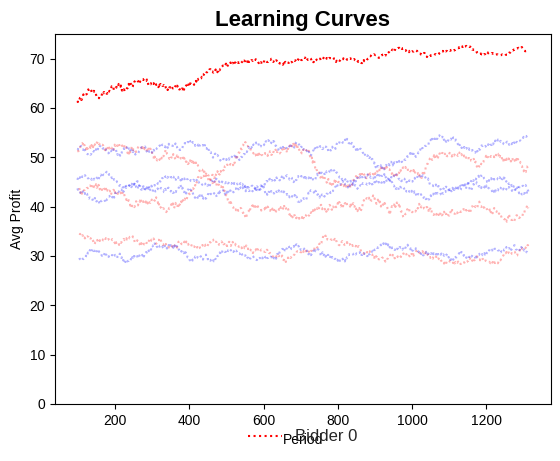

In [12]:
log.graphLearning(rolling_window = 100, trackBuyersIdx=[0], trackSellersIdx=[])

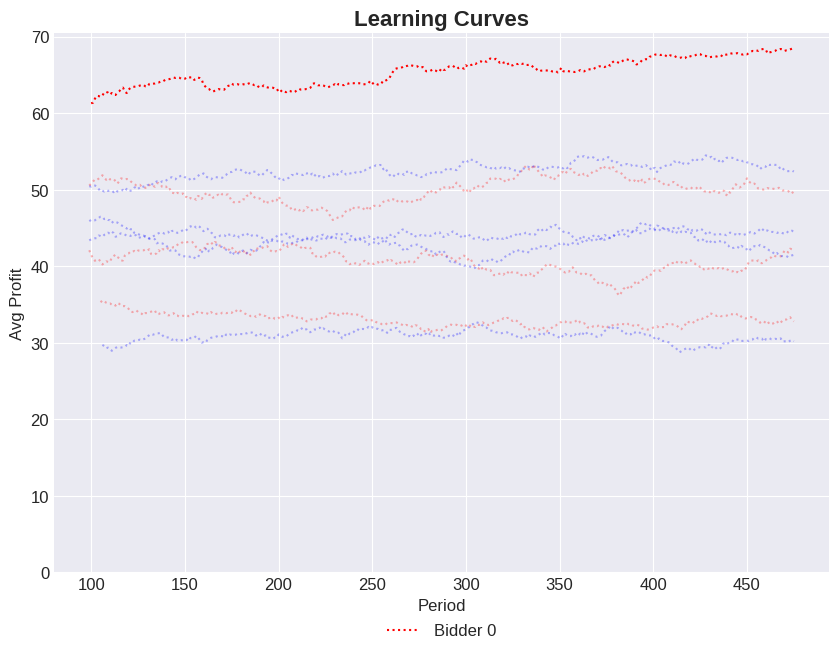

In [15]:
log.graphLearning(rolling_window = 100, trackBuyersIdx=[0], trackSellersIdx=[])

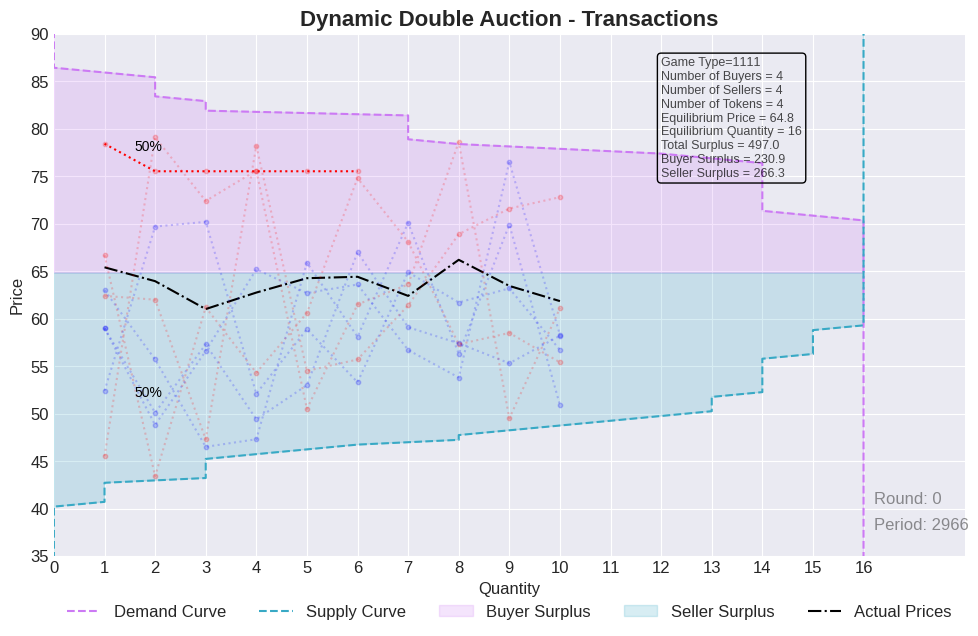

In [14]:
log.graphSales(0, period-5, trackBuyersIdx=[0], trackSellersIdx=[])

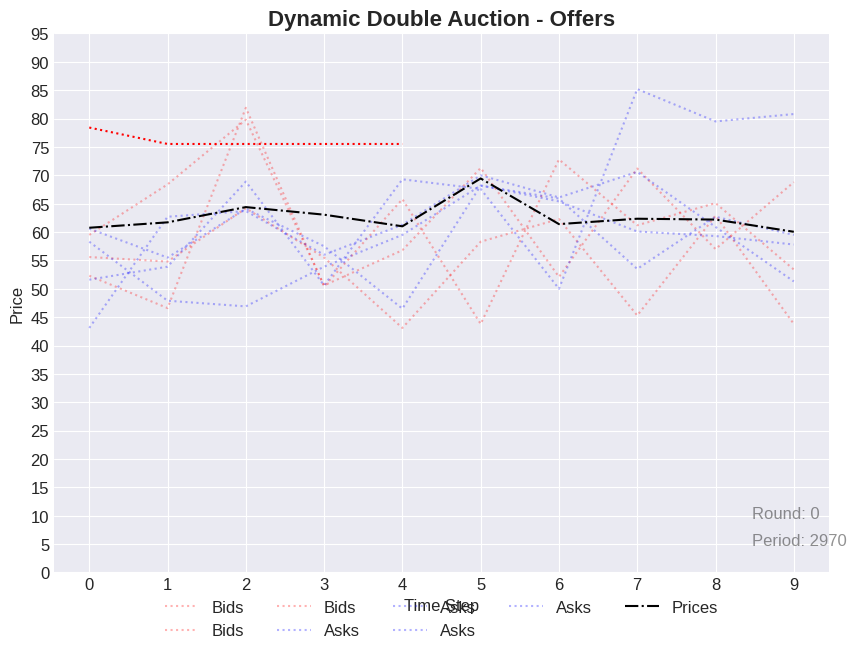

In [15]:
log.graphOffers(0, period-1, trackBuyersIdx=[0], trackSellersIdx=[])

In [16]:
log.graphTraining(maxNumPeriods=period-1, skip = int((period-1)/50), trackBuyersIdx = [0])

In [12]:
memory = pd.DataFrame(buyers[0].algo.memory, columns = ['state', 'action', 'reward', 'newState', 'done'])
memory.action.value_counts()

ValueError: DataFrame constructor not properly called!

In [11]:
memory

,state,action,reward,newState,done
0,"[0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",6,0.359843,"[1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",False
1,"[1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",9,0.179150,"[2, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",False
2,"[2, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",0,0.000000,"[3, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",False
3,"[3, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",9,0.170154,"[4, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",False
4,"[4, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",0,0.000000,"[5, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",False
...,...,...,...,...,...
8077,"[7, 2, 73.55701446533203, 0, 39.5, 1, True, Tr...",0,0.000000,"[8, 2, 77.2, 3, 48.4, 3, True, True, 62.8, Tru...",False
8078,"[8, 2, 77.2, 3, 48.4, 3, True, True, 62.8, Tru...",3,0.000000,"[9, 2, 79.0, 2, 44.8, 1, True, True, 61.9, Tru...",False
8079,"[9, 2, 79.0, 2, 44.8, 1, True, True, 61.9, Tru...",tensor(7),0.000000,"[10, 2, 82.6, 1, 51.9, 2, True, True, 67.25, T...",True
8080,"[0, 0, 82.6, 1, 51.9, 2, True, True, 67.25, Tr...",tensor(8),0.225021,"[1, 1, 77.23982238769531, 0, 49.4, 2, True, Tr...",False


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'memory' contains your data
memory = pd.DataFrame(buyers[0].algo.memory, columns=['state', 'action', 'reward', 'newState', 'done'])

# Calculate the rolling mean and standard deviation for actions and rewards
window_size = 100  # You can adjust the window size as needed
rolling_action_mean = memory['action'].rolling(window=window_size).mean()
rolling_reward_mean = memory['reward'].rolling(window=window_size).mean()
rolling_action_std = memory['action'].rolling(window=window_size).std()
rolling_reward_std = memory['reward'].rolling(window=window_size).std()

# Plot the rolling means and standard deviations separately for actions and rewards
plt.figure(figsize=(12, 6))

# Plot Rolling Mean and Std for Actions
plt.subplot(2, 1, 1)
plt.plot(rolling_action_mean, label='Rolling Mean of Actions')
plt.fill_between(
    range(len(memory)),
    rolling_action_mean - rolling_action_std,
    rolling_action_mean + rolling_action_std,
    alpha=0.3,
    label='Rolling Std of Actions'
)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.title('Rolling Mean and Standard Deviation of Actions')

# Plot Rolling Mean and Std for Rewards
plt.subplot(2, 1, 2)
plt.plot(rolling_reward_mean, label='Rolling Mean of Rewards')
plt.fill_between(
    range(len(memory)),
    rolling_reward_mean - rolling_reward_std,
    rolling_reward_mean + rolling_reward_std,
    alpha=0.3,
    label='Rolling Std of Rewards'
)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.title('Rolling Mean and Standard Deviation of Rewards')

plt.tight_layout()
plt.show()


ValueError: DataFrame constructor not properly called!